In [1]:
import pandas as pd 
import json

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [2]:
def load_molecular_data(smiles):
    with open(f'../copol_prediction/output/molecule_properties/{smiles}.json', 'r') as handle:
        d = json.load(handle)

    # for charges, fukui_electrophilicity, fukui_nucleophilicity, fukui_radical
    # it is a dict. take the min, max, mean of the values of the dict and make a new key/value pairs in the root 
    # of d
    for key in ['charges', 'fukui_electrophilicity', 'fukui_nucleophilicity', 'fukui_radical']:
        d[key + '_min'] = min(d[key].values())
        d[key + '_max'] = max(d[key].values())
        d[key + '_mean'] = sum(d[key].values()) / len(d[key].values())

    d['dipole_x'] = d['dipole'][0]
    d['dipole_y'] = d['dipole'][1]
    d['dipole_z'] = d['dipole'][2]

    return d

In [3]:
def molecular_features(smiles):
    d = load_molecular_data(smiles)
    # select only the keys for which we have float values
    d = {k: v for k, v in d.items() if isinstance(v, float)}
    return d

In [4]:
molecular_features('C_C=C_C')

{'ip': 13.682973015266317,
 'ip_corrected': 8.836973015266317,
 'ea': 1.2218398518750326,
 'homo': -0.3816405868399534,
 'lumo': -0.1874791546885192,
 'global_electrophilicity': 0.27258173104659283,
 'global_nucleophilicity': -8.836973015266317,
 'best_conformer_energy': -12.612394464140023,
 'charges_min': -0.10224603368115683,
 'charges_max': 0.04109184075729364,
 'charges_mean': -1.9024134119878985e-16,
 'fukui_electrophilicity_min': -0.05083731556660036,
 'fukui_electrophilicity_max': 0.15345645443935063,
 'fukui_electrophilicity_mean': 0.08333333333333313,
 'fukui_nucleophilicity_min': -0.026684857821392627,
 'fukui_nucleophilicity_max': 0.13523914792194044,
 'fukui_nucleophilicity_mean': 0.08333333333340077,
 'fukui_radical_min': -0.038761080705294174,
 'fukui_radical_max': 0.11937515617831551,
 'fukui_radical_mean': 0.08333333333336708,
 'dipole_x': -3.718452829648182e-07,
 'dipole_y': -3.899439447074193e-07,
 'dipole_z': -2.845134707431372e-09}

In [5]:
with open('all_reactions.json', 'r') as file:
    data = json.load(file)

def is_within_deviation(actual_product, expected_product, deviation=0.10):
    if expected_product == 0:
        return actual_product == 0
    return abs(actual_product - expected_product) / abs(expected_product) <= deviation


for entry in data:
    r1 = entry['r_values'].get('constant_1')
    r2 = entry['r_values'].get('constant_2')
    r_product = entry.get('r-product')
    
    if r_product is None:
        entry['r-product_filter'] = False
        continue
    
    actual_product = r1 * r2
    
    # Check for division by zero
    if r_product == 0:
        deviation = float('inf') if actual_product != 0 else 0
    else:
        deviation = abs(actual_product - r_product) / abs(r_product)
    
    if is_within_deviation(actual_product, r_product):
        entry['r-product_filter'] = False
    else:
        entry['r-product_filter'] = True # reaction should be filtered out


def filter_conf_intervals(row):
    if 'conf_intervals' in row and 'constant_conf_1' in row['conf_intervals'] and 'constant_conf_2' in row['conf_intervals']:
        conf_1 = row['conf_intervals']['constant_conf_1']
        conf_2 = row['conf_intervals']['constant_conf_2']
        
        # Ensure 'r1' and 'r2' are correctly retrieved from the row
        r1 = row.get('r_values', {}).get('constant_1')
        r2 = row.get('r_values', {}).get('constant_2')
        
        if r1 is not None and r2 is not None and conf_1 is not None and conf_2 is not None:
            # Filter condition: Confidence intervals should not be greater than the corresponding r-values
            return (conf_1 <= 1 * r1) and (conf_2 <= 1 * r2)
    
    # If conditions are not met, return True by default, meaning the row will not be filtered out
    return True

In [6]:
# Convert JSON data to DataFrame
df_full = pd.DataFrame(data)

print('Initial datapoints: ', len(df_full))
df_full = df_full[df_full.apply(filter_conf_intervals, axis=1)]
print('Datapoints after confidence filter:', len(df_full))

# Separate the filtered data
df_filtered = df_full[df_full['r-product_filter'] == False]
print('Datapoints after r-product filter:', len(df_filtered))

Initial datapoints:  1138
Datapoints after confidence filter: 1060
Datapoints after r-product filter: 1037


In [7]:
df_filtered['r1'] = df_filtered['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
df_filtered['r2'] = df_filtered['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)

df_filtered['calculation_method'].fillna('None', inplace=True)
df_filtered['polymerization_type'].fillna('None', inplace=True)

df_filtered.dropna(subset=['r1', 'r2',  'monomer1_s', 'monomer2_s', 'temperature', 'calculation_method', 'polymerization_type'], inplace=True)

# if polymerization type is "bulk" then set solvent to "bulk"
df_filtered.loc[df_filtered['polymerization_type'] == 'bulk', 'solvent'] = 'bulk'

df_filtered.dropna(subset=['solvent'], inplace=True)

df_filtered.drop(columns=['r-product_filter', 'r_values', 'r-product', 'monomer1_data', 'monomer2_data', 'conf_intervals'], inplace=True)

print(len(df_filtered))

728


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_40779/1576398088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['r1'] = df_filtered['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_40779/1576398088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['r2'] = df_filtered['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x els

In [8]:
df_filtered_flipped = []

# create the same rows, but with flipped monomers, i.e. monomer1_s <-> monomer2_s, monomer1 <-> monomer2, and r1 <-> r2
for index, row in df_filtered.iterrows():
    flipped_row = row.copy()
    flipped_row['monomer1_s'] = row['monomer2_s']
    flipped_row['monomer2_s'] = row['monomer1_s']
    flipped_row['monomer1'] = row['monomer2']
    flipped_row['monomer2'] = row['monomer1']
    flipped_row['r1'] = row['r2']
    flipped_row['r2'] = row['r1']
    df_filtered_flipped.append(flipped_row)

df_filtered_flipped = pd.DataFrame(df_filtered_flipped)
df_filtered_flipped

,file,monomer1_s,monomer2_s,monomer1,monomer2,temperature,temperature_unit,solvent,method,source,calculation_method,polymerization_type,logP,r1,r2
0,paper01.json,C=Cc1ccccc1,C=C(C)C(=O)O,styrene,methacrylic acid,60.0,°C,ClC(Cl)(Cl)Cl,solvent,https://doi.org/10.1002/macp.1985.021860819,Kelen-Tudor,free radical,2.55290,0.06,0.54
1,paper01.json,C=Cc1ccccc1,C=C(C)C(=O)O,styrene,methacrylic acid,60.0,°C,ClC(Cl)Cl,solvent,https://doi.org/10.1002/macp.1985.021860819,Kelen-Tudor,free radical,1.98640,0.08,0.51
2,paper01.json,C=Cc1ccccc1,C=C(C)C(=O)O,styrene,methacrylic acid,60.0,°C,CC(C)=O,solvent,https://doi.org/10.1002/macp.1985.021860819,Kelen-Tudor,free radical,0.59530,0.65,0.43
3,paper01.json,C=Cc1ccccc1,C=C(C)C(=O)O,styrene,methacrylic acid,60.0,°C,C1COCCO1,solvent,https://doi.org/10.1002/macp.1985.021860819,Kelen-Tudor,free radical,0.03320,0.59,0.41
4,paper01.json,C=Cc1ccccc1,C=C(C)C(=O)O,styrene,methacrylic acid,60.0,°C,CC#N,solvent,https://doi.org/10.1002/macp.1985.021860819,Kelen-Tudor,free radical,0.52988,0.29,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,paper_99.json,C=CC#N,C=CC(=O)OCCCCCCCC,Acrylonitrile,Octyl acrylate,60.0,°C,CC(C)(C)O,solvent,https://doi.org/10.1002/app.1960.070040111,Fineman and Ross,free radical,0.77720,0.83,1.93
1134,paper_99.json,C=CC#N,C=CC(=O)OCCCCCCCCCCCCCCCCCC,Acrylonitrile,Octadecyl acrylate,60.0,°C,CC(C)(C)O,solvent,https://doi.org/10.1002/app.1960.070040111,Fineman and Ross,free radical,0.77720,0.68,1.74
1135,paper_99.json,C=C(Cl)Cl,C=CC(=O)OCCCC,Vinylidene chloride,Butyl acrylate,50.0,°C,CC(C)(C)O,solvent,https://doi.org/10.1002/app.1960.070040111,Fineman and Ross,free radical,0.77720,0.83,0.88
1136,paper_99.json,C=C(Cl)Cl,C=CC(=O)OCCCCCCCC,Vinylidene chloride,Octyl acrylate,50.0,°C,CC(C)(C)O,solvent,https://doi.org/10.1002/app.1960.070040111,Fineman and Ross,free radical,0.77720,0.70,0.87


In [9]:
from rdkit import Chem
from rdkit.Chem.Descriptors import MolLogP

In [10]:
# now, add the features for each monomer by loading the corresponding JSON file with `molecular_features` based on the monomer{i}_s column
def add_molecular_features(df): 
    new_rows = []
    for index, row in df.iterrows():
        try:
            monomer1_s = row['monomer1_s']
            monomer2_s = row['monomer2_s']
            monomer1 = row['monomer1']
            monomer2 = row['monomer2']
            temperature = row['temperature']
            solvent = row['solvent']
            calculation_method = row['calculation_method']
            polymerization_method = row['polymerization_type']
            if solvent == 'bulk':
                solvent_logp = 0
            else:
                solvent_logp = MolLogP(Chem.MolFromSmiles(solvent))

            monomer1_data = molecular_features(monomer1_s)
            monomer2_data = molecular_features(monomer2_s)
            
            # add _1 to the keys of monomer1_data and _2 to the keys of monomer2_data
            monomer1_data = {f'{k}_1': v for k, v in monomer1_data.items()}
            monomer2_data = {f'{k}_2': v for k, v in monomer2_data.items()}

            # now, create new dict with all the data 
            new_row = {**row, **monomer1_data, **monomer2_data, 'temperature': temperature, 'solvent': solvent, 'calculation_method': calculation_method, 'polymerization_method': polymerization_method, 'solvent_logp': solvent_logp}

            new_rows.append(new_row)
        except FileNotFoundError as e: 
            print(f"File not found: {e}")
    return pd.DataFrame(new_rows) 

In [11]:
df_filtered = add_molecular_features(df_filtered)
df_filtered_flipped = add_molecular_features(df_filtered_flipped)

File not found: [Errno 2] No such file or directory: '../copol_prediction/output/molecule_properties/C=Cc1cc(O)ccc1O.O=C(O)c1ccccc1.O=C(O)c1ccccc1.json'
File not found: [Errno 2] No such file or directory: '../copol_prediction/output/molecule_properties/C=Cc1cc(O)ccc1O.O=C(O)c1ccccc1.O=C(O)c1ccccc1.json'
File not found: [Errno 2] No such file or directory: '../copol_prediction/output/molecule_properties/C/C=C/C.json'
File not found: [Errno 2] No such file or directory: '../copol_prediction/output/molecule_properties/C/C=C/C.json'
File not found: [Errno 2] No such file or directory: '../copol_prediction/output/molecule_properties/C/C=C\\C.json'
File not found: [Errno 2] No such file or directory: '../copol_prediction/output/molecule_properties/C/C=C\\C.json'
File not found: [Errno 2] No such file or directory: '../copol_prediction/output/molecule_properties/C=CC(=O)[O-].C=CC(=O)[O-].[Zn+2].json'
File not found: [Errno 2] No such file or directory: '../copol_prediction/output/molecule_pr

In [12]:
len(df_filtered)

669

In [13]:
df_filtered[df_filtered['method']=='bulk']

,file,monomer1_s,monomer2_s,monomer1,monomer2,temperature,temperature_unit,solvent,method,source,...,fukui_nucleophilicity_max_2,fukui_nucleophilicity_mean_2,fukui_radical_min_2,fukui_radical_max_2,fukui_radical_mean_2,dipole_x_2,dipole_y_2,dipole_z_2,polymerization_method,solvent_logp
5,paper02.json,C=Cc1ccccn1,C=C(C)C(=O)O,2-Vinylpyridine,Methacrylic Acid,70.0,°C,bulk,bulk,https://doi.org/10.1021/ja01122a053,...,0.193829,0.083333,-0.029651,0.199461,0.083333,-0.412334,-0.451571,0.376409,bulk,0.0000
68,paper_169.json,C=Cc1ccccc1,C=Cc1cccc2c1[nH]c1ccccc12,Styrene,Vinyl Carbazole,70.0,°C,c1ccccc1,bulk,"Journal of Polymer Science Vol. IV, pp. 215-21...",...,0.067678,0.038462,0.012596,0.063445,0.038462,-0.113567,0.614863,0.068897,free radical,1.6866
69,paper_169.json,C=C(C)C(=O)OC,C=Cc1cccc2c1[nH]c1ccccc12,Methyl Methacrylate,Vinyl Carbazole,70.0,°C,c1ccccc1,bulk,"Journal of Polymer Science Vol. IV, pp. 215-21...",...,0.067678,0.038462,0.012596,0.063445,0.038462,-0.113567,0.614863,0.068897,free radical,1.6866
70,paper_169.json,C=Cc1ccccc1,C=C(Cl)CCl,Styrene,"1,2-Dichloro-2-propene",70.0,°C,c1ccccc1,bulk,"Journal of Polymer Science Vol. IV, pp. 215-21...",...,0.318609,0.111111,-0.035264,0.282111,0.111111,-0.373286,0.006694,0.833315,free radical,1.6866
71,paper_169.json,C=C(C)C(=O)OC,C=C(Cl)CCl,Methyl Methacrylate,"1,2-Dichloro-2-propene",70.0,°C,c1ccccc1,bulk,"Journal of Polymer Science Vol. IV, pp. 215-21...",...,0.318609,0.111111,-0.035264,0.282111,0.111111,-0.373286,0.006694,0.833315,free radical,1.6866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,paper_776.json,C=Cc1ccccc1,C=CSC,Styrene,Methyl Vinyl Sulfide,60.0,°C,O,bulk,https://doi.org/10.1021/ja01157a003,...,0.550493,0.100000,-0.066296,0.487713,0.100000,0.372830,0.283551,0.718924,free radical,-0.8247
630,paper_776.json,C=COC(C)=O,C=CSC,Vinyl Acetate,Methyl Vinyl Sulfide,60.0,°C,O,bulk,https://doi.org/10.1021/ja01157a003,...,0.550493,0.100000,-0.066296,0.487713,0.100000,0.372830,0.283551,0.718924,free radical,-0.8247
637,paper_795.json,C=COC(C)=S,C=CN1C(=O)CCC1=O,Vinyl thioacetate,N-Vinylsuccinimide,60.0,°C,c1ccccc1,bulk,https://doi.org/10.1007/BF00549745,...,0.155082,0.062500,-0.011413,0.157335,0.062500,-0.813073,0.208070,-0.051568,free radical,1.6866
638,paper_795.json,C=COC(C)=S,C=CN1C(=O)c2ccccc2C1=O,Vinyl thioacetate,N-Vinylphthalimide,60.0,°C,c1ccccc1,bulk,https://doi.org/10.1007/BF00549745,...,0.108985,0.050000,0.010853,0.123950,0.050000,1.198961,-0.243353,-0.002086,free radical,1.6866


## Modeling

In [14]:
method_mapping = {
    'bulk': 0,
    'Bulk': 0,
    'solvent': 1,
    'Solvent': 1,
    'emulsion': 2,
    'suspension': 3,
    'photopolymerization': 10,
    'None': 20
}

calculation_method_mapping = {
    'Kelen-Tudor': 0,
    'Fineman-Ross': 1,
    'Fineman and Ross': 1,
    'Fineman Ross method': 1,
    'fundamental equation of copolymerisation': 2,
    'Mayo and Lewis': 3,
    'Mayo-Lewis differential method': 3,
    'Mayo and Lewis method': 3,
    'Mayo and Lewis intersection method': 3,
    'Intersection method': 3,
    'intersection method of Mayo and Lewis': 3,
    'Joshi-Joshi': 4,
    'Schwan and Price': 5,
    'Alfrey-Price': 6,
    'Alfrey and Goldfinger': 6,
    'regression analysis': 7,
    'nonlinear least squares technique': 7,
    'non-linear regression': 7,
    'nonlinear least squares': 7,
    'nonlinear least squares analysis': 7,
    'nonlinear least squares procedure': 7,
    'approximations successives': 7,
    'graphical solution of the copolymerization equation': 8,
    'graphical method of intersections': 8,
    'graphical evaluation': 8,
    'graphical': 8,
    'graphic method': 8,
    'graphic solution': 8,
    'logarithm plot': 9,
    'polarization': 10,
    'Nuclear magnetic resonance spectroscopy': 11,
    'NMR spectroscopy': 11,
    'NMR analysis': 11,
    'carbon elemental analyses': 12,
    'nitrogen analyses': 13,
    'Ghosh-Palit': 14,
    'curve fitting': 15,
    'curve-fitting technique': 15,
    'curve-fitting': 15,
    'Multiparameter correlation equation': 16,
    'Yserielve-Brokhina-Roskin': 17,
    'Yezrielev method': 17,
    'Ezrievlev and co-workers': 17,
    'Shtraikhman approach': 18,
    'differential form of the copolymer equation': 19,
    'penultimate model': 20,
    'penultimate mu model': 20,
    'Alfrey-Price equation': 21,
    'assumed': 22,
    'Optimizer': 23,
    'Barb': 24,
    'previous paper': 30,
    'not provided': 30,
    'not specified': 30,
    'EVM Program': 27,
    'Tidwell-Mortimer': 28,
    'Grant': 29,
    'null': 30,
    'None': 30
}

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

def map_method(X, column, mapping):
    return X[column].map(mapping).values.reshape(-1, 1)

# Define the features
numerical_features = ['temperature', 'ip_corrected_1', 'ea_1', 'homo_1', 'lumo_1',
                      'global_electrophilicity_1', 'global_nucleophilicity_1',
                      'best_conformer_energy_1', 'charges_min_1', 'charges_max_1',
                      'charges_mean_1', 'fukui_electrophilicity_min_1',
                      'fukui_electrophilicity_max_1', 'fukui_electrophilicity_mean_1',
                      'fukui_nucleophilicity_min_1', 'fukui_nucleophilicity_max_1',
                      'fukui_nucleophilicity_mean_1', 'fukui_radical_min_1',
                      'fukui_radical_max_1', 'fukui_radical_mean_1', 'dipole_x_1',
                      'dipole_y_1', 'dipole_z_1',  'ip_corrected_2', 'ea_2', 'homo_2',
                      'lumo_2', 'global_electrophilicity_2', 'global_nucleophilicity_2',  
                      'charges_min_2', 'charges_max_2', 'charges_mean_2', 
                      'fukui_electrophilicity_min_2', 'fukui_electrophilicity_max_2', 
                      'fukui_electrophilicity_mean_2', 'fukui_nucleophilicity_min_2', 
                      'fukui_nucleophilicity_max_2', 'fukui_nucleophilicity_mean_2', 
                      'fukui_radical_min_2', 'fukui_radical_max_2', 'fukui_radical_mean_2', 
                      'dipole_x_2', 'dipole_y_2', 'dipole_z_2', 'solvent_logp']

categorical_features = ['polymerization_type']

# Define the transformer
transformer = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_features)
])

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Create the target variable for both DataFrames
df_filtered['r1r2'] = df_filtered['r1'] * df_filtered['r2']
df_filtered_flipped['r1r2'] = df_filtered_flipped['r1'] * df_filtered_flipped['r2']

# Combine the two DataFrames
combined_df = pd.concat([df_filtered])

# Fit and transform the features using the transformer
X_combined = transformer.fit_transform(combined_df)

# Create a DataFrame with the transformed features
categorical_feature_names = transformer.named_transformers_['categorical'].get_feature_names_out(categorical_features)

feature_names = numerical_features + list(categorical_feature_names) + \
                ['calculation_method_encoded', 'polymerization_method_encoded']

X_combined_df = pd.DataFrame(X_combined, columns=feature_names)

# Append the target variable to the DataFrame
X_combined_df['r1r2'] = combined_df['r1r2'].values

# Calculate Spearman correlation
correlation_results = {}
for column in X_combined_df.columns:
    if column != 'r1r2':
        corr, _ = spearmanr(X_combined_df[column], X_combined_df['r1r2'])
        correlation_results[column] = corr

# Convert to DataFrame for easy handling
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Spearman Correlation'])

# Sort by absolute correlation value
correlation_df['abs_corr'] = correlation_df['Spearman Correlation'].abs()
correlation_df.sort_values('abs_corr', ascending=False, inplace=True)

# Print correlation values
print(correlation_df)

# Plot the correlations
plt.figure()
correlation_df['Spearman Correlation'].plot(kind='bar')
plt.title('Spearman Correlation of Features with r1r2 (Combined Data)')
plt.ylabel('Spearman Correlation')
plt.xlabel('Features')
plt.xticks(rotation=90)

plt.savefig('spearman_all.png', dpi=300, bbox_inches='tight')
plt.show()


KeyError: 'categorical'

Fold 1
Fitting 3 folds for each of 100 candidates, totalling 300 fits


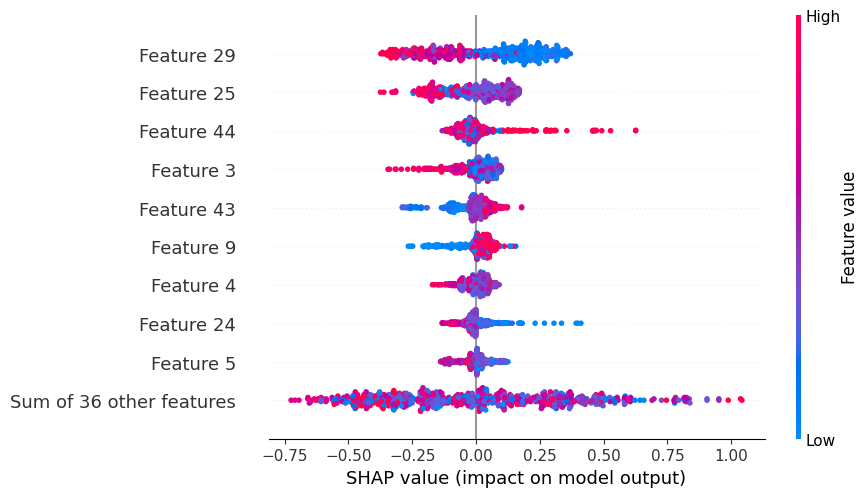

Train MSE: 0.1271, Train R2: 0.8729
Test MSE: 0.6639, Test R2: 0.4233
Best Hyperparameters for Fold 1: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.8888888888888888, 'n_estimators': 5000, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}
Fold 2
Fitting 3 folds for each of 100 candidates, totalling 300 fits


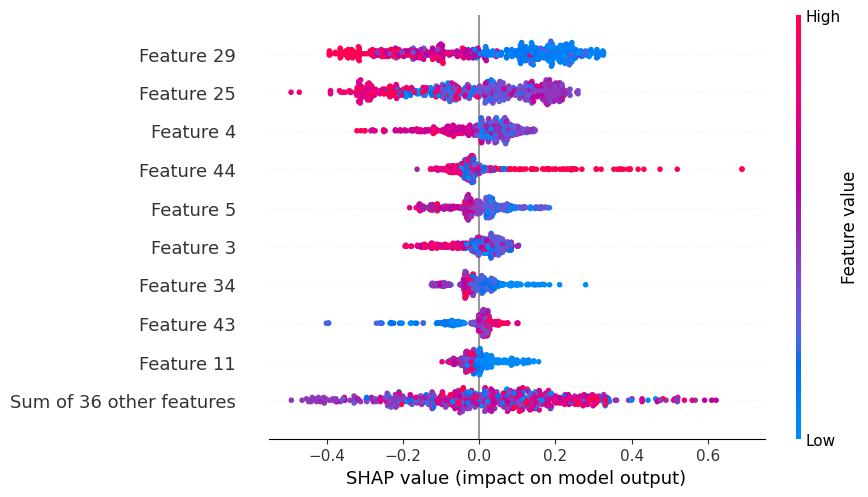

Train MSE: 0.2891, Train R2: 0.7109
Test MSE: 0.5017, Test R2: 0.5133
Best Hyperparameters for Fold 2: {'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 0.8888888888888888, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.004641588833612777, 'gamma': 0, 'colsample_bytree': 1.0}
Fold 3
Fitting 3 folds for each of 100 candidates, totalling 300 fits


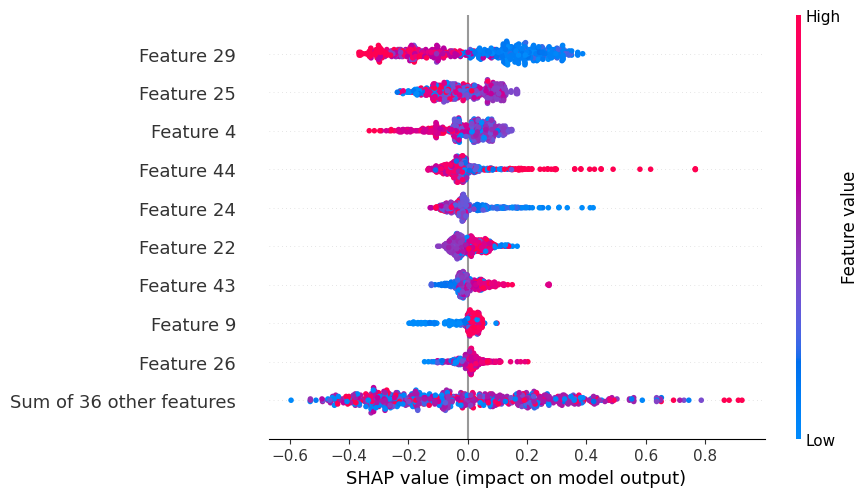

Train MSE: 0.1566, Train R2: 0.8434
Test MSE: 0.6456, Test R2: 0.2975
Best Hyperparameters for Fold 3: {'subsample': 0.8, 'reg_lambda': 0.5555555555555556, 'reg_alpha': 0.2222222222222222, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.021544346900318832, 'gamma': 0.1, 'colsample_bytree': 1.0}
Fold 4
Fitting 3 folds for each of 100 candidates, totalling 300 fits


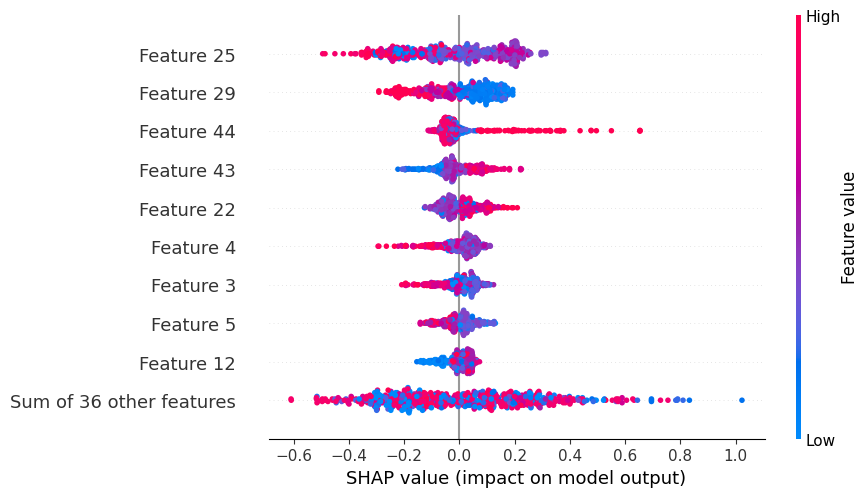

Train MSE: 0.1915, Train R2: 0.8085
Test MSE: 0.5357, Test R2: 0.5138
Best Hyperparameters for Fold 4: {'subsample': 0.8, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.021544346900318832, 'gamma': 0.2, 'colsample_bytree': 0.8}
Fold 5
Fitting 3 folds for each of 100 candidates, totalling 300 fits


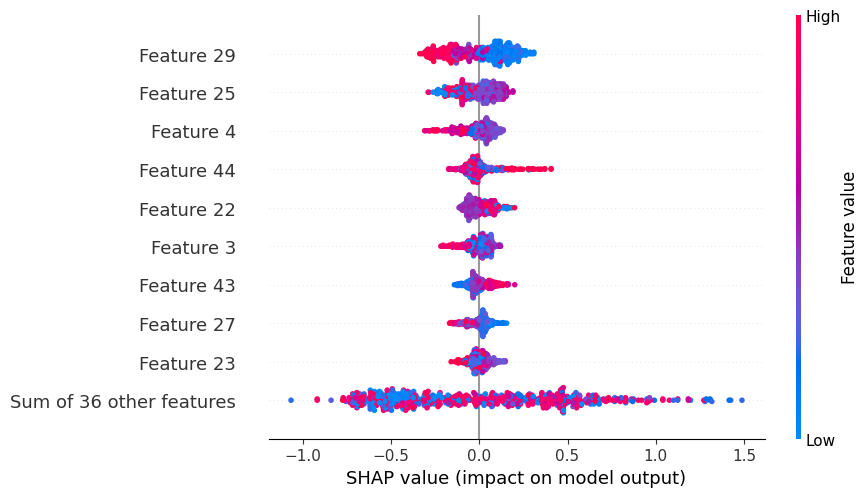

Train MSE: 0.0636, Train R2: 0.9364
Test MSE: 0.4547, Test R2: 0.5350
Best Hyperparameters for Fold 5: {'subsample': 0.6, 'reg_lambda': 0.3333333333333333, 'reg_alpha': 1.0, 'n_estimators': 5000, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.004641588833612777, 'gamma': 0.1, 'colsample_bytree': 0.6}
Fold 6
Fitting 3 folds for each of 100 candidates, totalling 300 fits


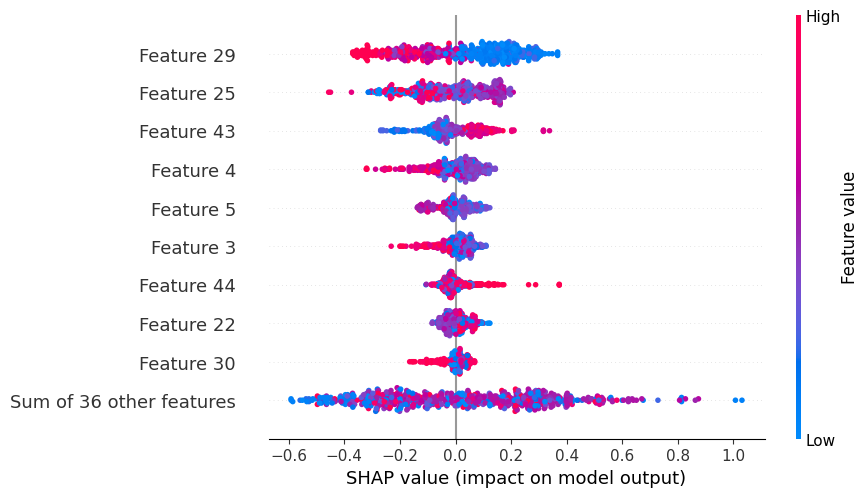

Train MSE: 0.1339, Train R2: 0.8661
Test MSE: 0.7224, Test R2: 0.2717
Best Hyperparameters for Fold 6: {'subsample': 0.8, 'reg_lambda': 0.1111111111111111, 'reg_alpha': 0.5555555555555556, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.004641588833612777, 'gamma': 0, 'colsample_bytree': 0.8}
Fold 7
Fitting 3 folds for each of 100 candidates, totalling 300 fits


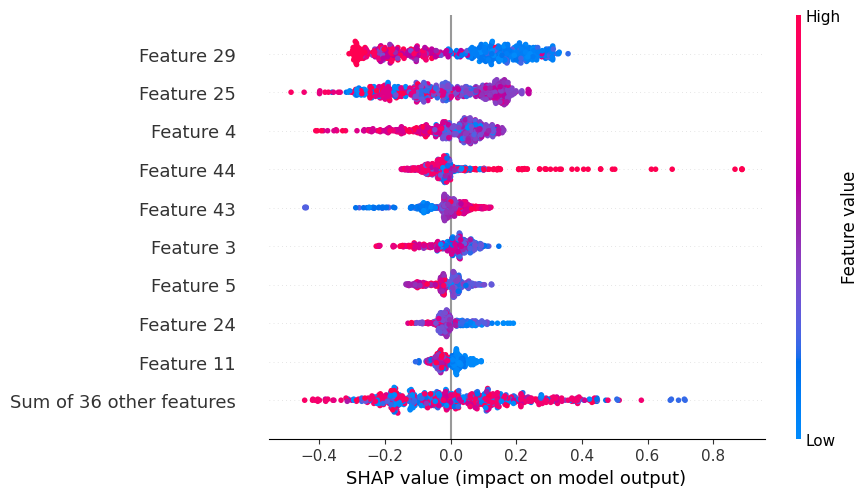

Train MSE: 0.2832, Train R2: 0.7168
Test MSE: 0.4953, Test R2: 0.4404
Best Hyperparameters for Fold 7: {'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 0.8888888888888888, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.004641588833612777, 'gamma': 0, 'colsample_bytree': 1.0}
Fold 8
Fitting 3 folds for each of 100 candidates, totalling 300 fits


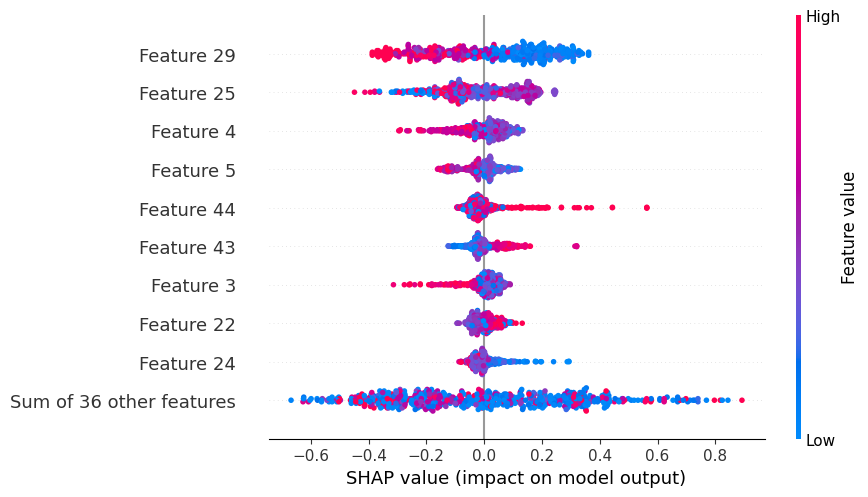

Train MSE: 0.1344, Train R2: 0.8656
Test MSE: 0.5091, Test R2: 0.4106
Best Hyperparameters for Fold 8: {'subsample': 0.8, 'reg_lambda': 0.1111111111111111, 'reg_alpha': 0.5555555555555556, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.004641588833612777, 'gamma': 0, 'colsample_bytree': 0.8}
Fold 9
Fitting 3 folds for each of 100 candidates, totalling 300 fits


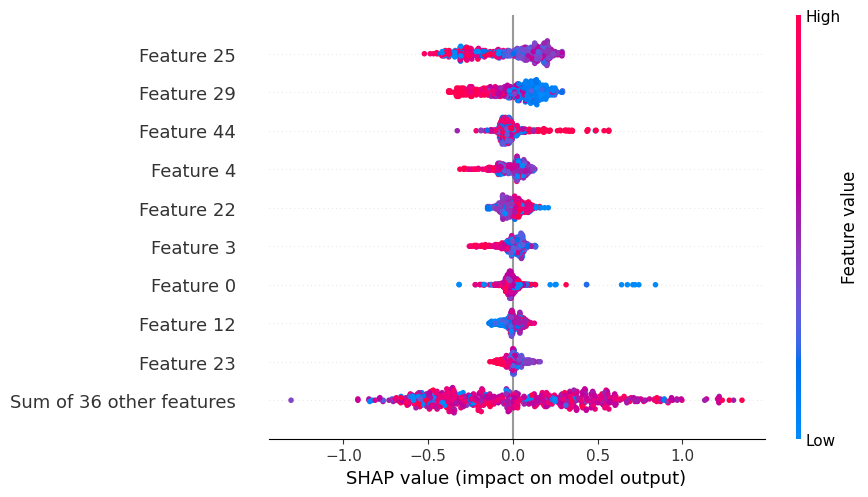

Train MSE: 0.0314, Train R2: 0.9686
Test MSE: 0.4679, Test R2: 0.5808
Best Hyperparameters for Fold 9: {'subsample': 0.8, 'reg_lambda': 0.6666666666666666, 'reg_alpha': 0.2222222222222222, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Fold 10
Fitting 3 folds for each of 100 candidates, totalling 300 fits


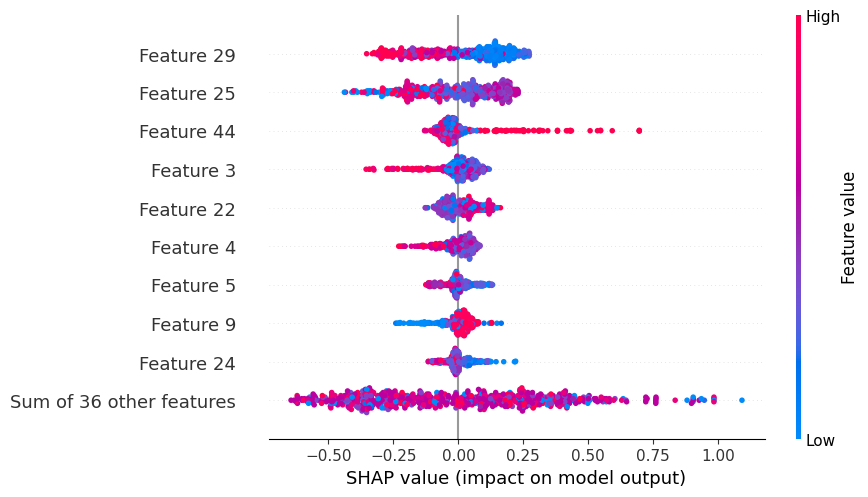

Train MSE: 0.1287, Train R2: 0.8713
Test MSE: 0.4847, Test R2: 0.3817
Best Hyperparameters for Fold 10: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.8888888888888888, 'n_estimators': 5000, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}

Average Train R2: 0.8460
Average Test R2: 0.4368


In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap

# Define the power transformer for the label
pt = PowerTransformer(method='yeo-johnson')

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000, 5000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': np.logspace(-3, 0, 10),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10)
}

# Implement K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_scores = []

all_y_true = []
all_y_pred = []
all_y_train_true = []
all_y_train_pred = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df_filtered), 1):
    print(f"Fold {fold}")
    
    # Split the data
    train = df_filtered.iloc[train_idx]
    test = df_filtered.iloc[test_idx]
    
    #train_flipped = df_filtered_flipped.iloc[train_idx]
    #test_flipped = df_filtered_flipped.iloc[test_idx]
    train = pd.concat([train])
    test = pd.concat([test])
    
    # Create the target variable
    train['r1r2'] = train['r1'] * train['r2']
    test['r1r2'] = test['r1'] * test['r2']
    
    # Fit and transform the features
    X_train = transformer.fit_transform(train)
    X_test = transformer.transform(test)
    
    # Transform the label
    y_train = pt.fit_transform(train['r1r2'].values.reshape(-1, 1)).ravel()
    y_test = pt.transform(test['r1r2'].values.reshape(-1, 1)).ravel()
    
    # Define the model
    model = XGBRegressor(random_state=42)
    
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                       n_iter=100, cv=3, verbose=1, 
                                       random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train, 
                    #   early_stopping_rounds=10, 
                      eval_set=[(X_test, y_test)],
                      verbose=False)
    
    # Get the best model
    best_model = random_search.best_estimator_
    
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_train)
    shap.plots.beeswarm(shap_values)
    
    # Make predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Store true and predicted values for train
    all_y_train_true.extend(y_train)  # Appending the true values (train)
    all_y_train_pred.extend(y_pred_train)  # Appending the predicted values (train)
    
    # Store true and predicted values for test
    all_y_true.extend(y_test)  # Appending the true values (test)
    all_y_pred.extend(y_pred_test)  # Appending the predicted values (test)
    
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"Train MSE: {mse_train:.4f}, Train R2: {r2_train:.4f}")
    print(f"Test MSE: {mse_test:.4f}, Test R2: {r2_test:.4f}")
    print(f"Best Hyperparameters for Fold {fold}: {random_search.best_params_}")

    
    fold_scores.append((r2_train, r2_test))

# Calculate average scores across all folds
avg_train_r2 = np.mean([score[0] for score in fold_scores])
avg_test_r2 = np.mean([score[1] for score in fold_scores])

print(f"\nAverage Train R2: {avg_train_r2:.4f}")
print(f"Average Test R2: {avg_test_r2:.4f}")


In [25]:
df_filtered.to_json("data_old.json", orient="records", indent=4)

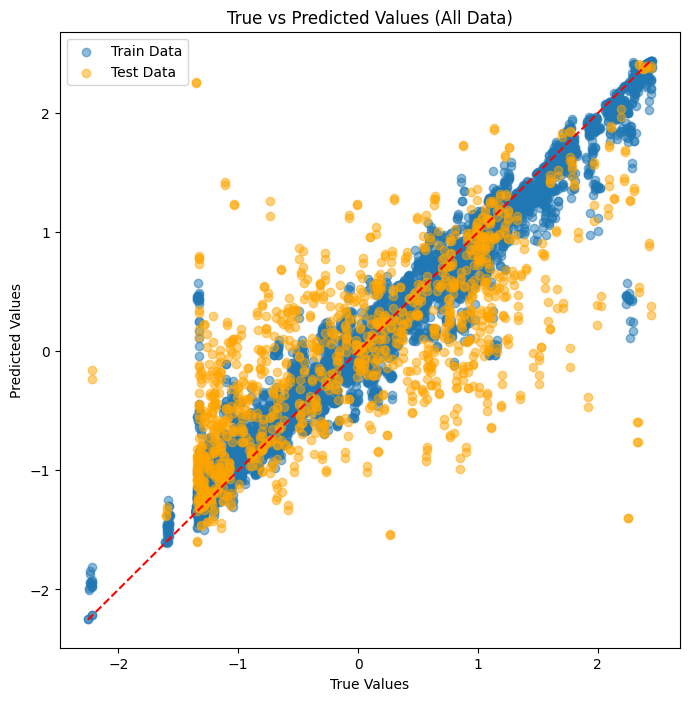

In [18]:
import matplotlib.pyplot as plt

# Plot true vs predicted values for all data
plt.figure(figsize=(8, 8))
plt.scatter(all_y_train_true, all_y_train_pred, alpha=0.5, label='Train Data')
plt.scatter(all_y_true, all_y_pred, alpha=0.5, label='Test Data', color='orange')
plt.plot([min(all_y_true + all_y_train_true), max(all_y_true + all_y_train_true)],
         [min(all_y_true + all_y_train_true), max(all_y_true + all_y_train_true)],
         color='red', linestyle='--')  # Line y=x
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (All Data)')
plt.legend()
plt.savefig('pred_all_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Random selection of 200 train datapoints
train_indices = np.random.choice(len(all_y_train_true), 200, replace=False)
selected_y_train_true = np.array(all_y_train_true)[train_indices]
selected_y_train_pred = np.array(all_y_train_pred)[train_indices]

# Random selection of 100 test datapoints
test_indices = np.random.choice(len(all_y_true), 100, replace=False)
selected_y_true = np.array(all_y_true)[test_indices]
selected_y_pred = np.array(all_y_pred)[test_indices]

selected_y_train_true_inv = pt.inverse_transform(np.array(selected_y_train_true).reshape(-1, 1)).ravel()
selected_y_train_pred_inv = pt.inverse_transform(np.array(selected_y_train_pred).reshape(-1, 1)).ravel()

selected_y_true_inv = pt.inverse_transform(np.array(selected_y_true).reshape(-1, 1)).ravel()
selected_y_pred_inv = pt.inverse_transform(np.array(selected_y_pred).reshape(-1, 1)).ravel()

plt.figure(figsize=(8, 8))

plt.style.use('../data_extraction/plots_and_figures/lamalab.mplstyle')

plt.scatter(selected_y_train_true_inv, selected_y_train_pred_inv, alpha=0.7, label='Train Data', color='#661124')
plt.plot([min(selected_y_train_true_inv), max(selected_y_train_true_inv)], 
         [min(selected_y_train_true_inv), max(selected_y_train_true_inv)], 
         color='grey', linestyle='--')  # Linie y=x

plt.scatter(selected_y_true_inv, selected_y_pred_inv, alpha=0.7, label='Test Data', color='#194A81')
plt.xlabel(r'True $r_{\text{product}}$', fontsize=16)
plt.ylabel(r'Predicted $r_{\text{product}}$', fontsize=16)
plt.xlim(-0.1, 2)
plt.ylim((-0.1,2))
plt.legend(fontsize=12)

plt.savefig('pred_200_XGBoost.png', dpi=300, bbox_inches='tight')
plt.show()


OSError: '../data_extraction/plots_and_figures/lamalab.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

<Figure size 800x800 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap

# Define molecular features (numerical only)
numerical_features = ['ip_corrected_1', 'ea_1', 'homo_1', 'lumo_1',
                      'global_electrophilicity_1', 'global_nucleophilicity_1',
                      'best_conformer_energy_1', 'charges_min_1', 'charges_max_1',
                      'charges_mean_1', 'fukui_electrophilicity_min_1',
                      'fukui_electrophilicity_max_1', 'fukui_electrophilicity_mean_1',
                      'fukui_nucleophilicity_min_1', 'fukui_nucleophilicity_max_1',
                      'fukui_nucleophilicity_mean_1', 'fukui_radical_min_1',
                      'fukui_radical_max_1', 'fukui_radical_mean_1', 'dipole_x_1',
                      'dipole_y_1', 'dipole_z_1',  'ip_corrected_2', 'ea_2', 'homo_2',
                      'lumo_2', 'global_electrophilicity_2', 'global_nucleophilicity_2',  
                      'charges_min_2', 'charges_max_2', 'charges_mean_2', 
                      'fukui_electrophilicity_min_2', 'fukui_electrophilicity_max_2', 
                      'fukui_electrophilicity_mean_2', 'fukui_nucleophilicity_min_2', 
                      'fukui_nucleophilicity_max_2', 'fukui_nucleophilicity_mean_2', 
                      'fukui_radical_min_2', 'fukui_radical_max_2', 'fukui_radical_mean_2', 
                      'dipole_x_2', 'dipole_y_2', 'dipole_z_2']

# Define transformer for molecular features only
transformer_molecular = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_features)
])

# Define transformer for all features (assuming the other transformer is already defined as 'transformer_all')
# transformer_all = (definition for transformer_all, if required)

# Define the power transformer for the label
pt = PowerTransformer(method='yeo-johnson')

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000, 5000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': np.logspace(-3, 0, 10),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10)
}

# Implement K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_scores = []

all_y_true = []
all_y_pred = []
all_y_train_true = []
all_y_train_pred = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df_filtered), 1):
    print(f"Fold {fold}")
    
    # Split the data
    train = df_filtered.iloc[train_idx]
    test = df_filtered.iloc[test_idx]
    
    train_flipped = df_filtered_flipped.iloc[train_idx]
    test_flipped = df_filtered_flipped.iloc[test_idx]
    train = pd.concat([train, train_flipped])
    test = pd.concat([test, test_flipped])
    
    # Create the target variable
    train['r1r2'] = train['r1'] * train['r2']
    test['r1r2'] = test['r1'] * test['r2']
    
    # Fit and transform the features using only molecular features
    X_train = transformer_molecular.fit_transform(train)
    X_test = transformer_molecular.transform(test)
    
    # Transform the label
    y_train = pt.fit_transform(train['r1r2'].values.reshape(-1, 1)).ravel()
    y_test = pt.transform(test['r1r2'].values.reshape(-1, 1)).ravel()
    
    # Define the model
    model = XGBRegressor(random_state=42)
    
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                       n_iter=100, cv=3, verbose=1, 
                                       random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train, 
                    #   early_stopping_rounds=10, 
                      eval_set=[(X_test, y_test)],
                      verbose=False)
    
    # Get the best model
    best_model = random_search.best_estimator_
    
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_train)
    shap.plots.beeswarm(shap_values)
    
    # Make predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Store true and predicted values for train
    all_y_train_true.extend(y_train)  # Appending the true values (train)
    all_y_train_pred.extend(y_pred_train)  # Appending the predicted values (train)
    
    # Store true and predicted values for test
    all_y_true.extend(y_test)  # Appending the true values (test)
    all_y_pred.extend(y_pred_test)  # Appending the predicted values (test)
    
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"Train MSE: {mse_train:.4f}, Train R2: {r2_train:.4f}")
    print(f"Test MSE: {mse_test:.4f}, Test R2: {r2_test:.4f}")
    print(f"Best Hyperparameters for Fold {fold}: {random_search.best_params_}")

    
    fold_scores.append((r2_train, r2_test))

# Calculate average scores across all folds
avg_train_r2 = np.mean([score[0] for score in fold_scores])
avg_test_r2 = np.mean([score[1] for score in fold_scores])

print(f"\nAverage Train R2: {avg_train_r2:.4f}")
print(f"Average Test R2: {avg_test_r2:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Random selection of 200 train datapoints
train_indices = np.random.choice(len(all_y_train_true), 200, replace=False)
selected_y_train_true = np.array(all_y_train_true)[train_indices]
selected_y_train_pred = np.array(all_y_train_pred)[train_indices]

# Random selection of 100 test datapoints
test_indices = np.random.choice(len(all_y_true), 100, replace=False)
selected_y_true = np.array(all_y_true)[test_indices]
selected_y_pred = np.array(all_y_pred)[test_indices]

selected_y_train_true_inv = pt.inverse_transform(np.array(selected_y_train_true).reshape(-1, 1)).ravel()
selected_y_train_pred_inv = pt.inverse_transform(np.array(selected_y_train_pred).reshape(-1, 1)).ravel()

selected_y_true_inv = pt.inverse_transform(np.array(selected_y_true).reshape(-1, 1)).ravel()
selected_y_pred_inv = pt.inverse_transform(np.array(selected_y_pred).reshape(-1, 1)).ravel()

plt.figure(figsize=(8, 8))

plt.style.use('../data_extraction/plots_and_figures/lamalab.mplstyle')

plt.scatter(selected_y_train_true_inv, selected_y_train_pred_inv, alpha=0.7, label='Train Data', color='#661124')
plt.plot([min(selected_y_train_true_inv), max(selected_y_train_true_inv)], 
         [min(selected_y_train_true_inv), max(selected_y_train_true_inv)], 
         color='grey', linestyle='--')  # Linie y=x

plt.scatter(selected_y_true_inv, selected_y_pred_inv, alpha=0.7, label='Test Data', color='#194A81')
plt.xlabel(r'True $r_{\text{product}}$', fontsize=16)
plt.ylabel(r'Predicted $r_{\text{product}}$', fontsize=16)
plt.xlim(-0.1, 2)
plt.ylim((-0.1,2))
plt.legend(fontsize=12)

plt.savefig('pred_200_XGBoost_just_monomer.png', dpi=300, bbox_inches='tight')
plt.show()